In [ ]:
#Creating CNN models with TF-Slim
import tensorflow as tf
from tensorflow.contrib import slim
W = slim.variable('w',shape=[7, 7, 3 , 3],initializer=tf.truncated_normal_initializer(stddev=0.1), 
                  regularizer=slim.l2_regularizer(0.07), device='/CPU:0')

net = slim.conv2d(inputs, 64, [11, 11], 4, padding='SAME', weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                weights_regularizer=slim.l2_regularizer(0.0007), scope='conv1')

# use repeat
net = slim.conv2d(net, 128, [3, 3], scope='con1_1')
net = slim.conv2d(net, 128, [3, 3], scope='con1_2')
net = slim.conv2d(net, 128, [3, 3], scope='con1_3')
net = slim.conv2d(net, 128, [3, 3], scope='con1_4')
net = slim.conv2d(net, 128, [3, 3], scope='con1_5')

net = slim.repeat(net, 5, slim.conv2d, 128, [3, 3], scope='con1')

#use stack
net = slim.conv2d(net, 64, [3, 3], scope='con1_1')
net = slim.conv2d(net, 64, [1, 1], scope='con1_2')
net = slim.conv2d(net, 128, [3, 3], scope='con1_3')
net = slim.conv2d(net, 128, [1, 1], scope='con1_4')
net = slim.conv2d(net, 256, [3, 3], scope='con1_5')

slim.stack(net, slim.conv2d, [(64, [3, 3]), (64, [1, 1]),(128, [3, 3]), (128, [1, 1]),
                              (256, [3, 3])], scope='con')

#we also have a scoping mechanism referred to as arg_scope, allowing users to pass a set of shared arguments to each operation defined in
#the same scope
with slim.arg_scope([slim.conv2d],padding='VALID',activation_fn=tf.nn.relu,weights_initializer=tf.truncated_normal_initializer(stddev=0.02) 
                    weights_regularizer=slim.l2_regularizer(0.0007)):
    net = slim.conv2d(inputs, 64, [11, 11], scope='con1')
    net = slim.conv2d(net, 128, [11, 11], padding='VALID', scope='con2')
    net = slim.conv2d(net, 256, [11, 11], scope='con3')
    net = slim.conv2d(net, 256, [11, 11], scope='con4')
    
    

In [ ]:
#construct the 16-layer version: 13 convolution layers plus 3 fully connected layers.
with slim.arg_scope([slim.conv2d, slim.fully_connected],activation_fn=tf.nn.relu,
                    weights_initializer=tf.truncated_normal_initializer(0.0,0.01),weights_regularizer=slim.l2_regularizer(0.0005)):
    net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='con1')
    net = slim.max_pool2d(net, [2, 2], scope='pool1')
    net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='con2')
    net = slim.max_pool2d(net, [2, 2], scope='pool2')
    net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='con3')
    net = slim.max_pool2d(net, [2, 2], scope='pool3')
    net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='con4')
    net = slim.max_pool2d(net, [2, 2], scope='pool4')
    net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='con5')
    net = slim.max_pool2d(net, [2, 2], scope='pool5')
    net = slim.fully_connected(net, 4096, scope='fc6')
    net = slim.dropout(net, 0.5, scope='dropout6')
    net = slim.fully_connected(net, 4096, scope='fc7')
    net = slim.dropout(net, 0.5, scope='dropout7')
    net = slim.fully_connected(net, 1000, activation_fn=None, scope='fc8')

In [ ]:
import sys
sys.path.append(r"C:\Users\xcm\Python\models\research\slim")
from tensorflow.contrib import slim
from datasets import dataset_utils
import tensorflow as tf
import os
target_dir = r'C:\Users\xcm\Python\QQ_PYTHON_NLP\vgg'
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
filename_queue = tf.train.string_input_producer(tf.train.match_filenames_once(r"C:\Users\xcm\Python\QQ_PYTHON_NLP\img\figure.png"))
image_reader = tf.WholeFileReader()
_, image_file = image_reader.read(filename_queue)
image = tf.image.decode_png(image_file)



from nets import vgg
image_size = vgg.vgg_16.default_image_size

from preprocessing import vgg_preprocessing
processed_im = vgg_preprocessing.preprocess_image(image,image_size,image_size,is_training=False)
processed_images = tf.expand_dims(processed_im, 0)

with slim.arg_scope(vgg.vgg_arg_scope()):
    logits, _ = vgg.vgg_16(processed_images,num_classes=1000,is_training=False)

probabilities = tf.nn.softmax(logits)
def vgg_arg_scope(weight_decay=0.0005):
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                        activation_fn=tf.nn.relu,weights_regularizer=slim.l2_regularizer(weight_decay),biases_initializer=tf.zeros_initializer):
        with slim.arg_scope([slim.conv2d], padding='SAME') as arg_sc:
            return arg_sc
        
import os
load_vars = slim.assign_from_checkpoint_fn(os.path.join(target_dir, 'vgg_16.ckpt'),
slim.get_model_variables('vgg_16'))

from datasets import imagenet
imagenet.create_readable_names_for_imagenet_labels()

names = []
with tf.Session() as sess:
    load_vars(sess)
    print(123)
    network_input, probabilities = sess.run([processed_images,probabilities])
    probabilities = probabilities[0, 0:]
    names_ = imagenet.create_readable_names_for_imagenet_labels()
    idxs = np.argsort(-probabilities)[:5]
    print(223)
    probs = probabilities[idxs]
    classes = np.array(names_.values())[idxs+1]
    for c,p in zip(classes,probs):
        print('Class: '+ c + ' |Prob: ' + str(p))

INFO:tensorflow:Restoring parameters from C:\Users\xcm\Python\QQ_PYTHON_NLP\vgg\vgg_16.ckpt
123


INFO:tensorflow:Restoring parameters from C:\Users\xcm\Python\QQ_PYTHON_NLP\vgg\vgg_16.ckpt


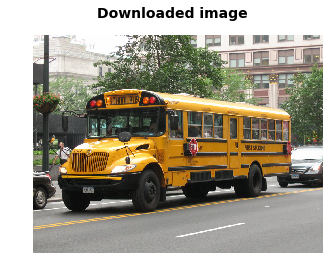

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


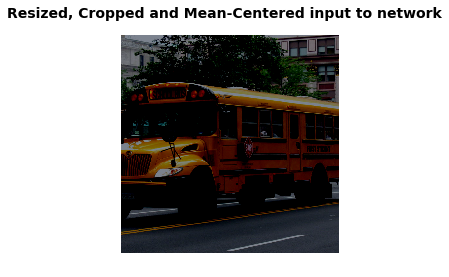

Probability 1.00 => [school bus]
Probability 0.00 => [minibus]
Probability 0.00 => [passenger car, coach, carriage]
Probability 0.00 => [trolleybus, trolley coach, trackless trolley]
Probability 0.00 => [cab, hack, taxi, taxicab]


In [5]:
%matplotlib inline
import sys
sys.path.append(r"C:\Users\xcm\Python\models\research\slim")
from tensorflow.contrib import slim
from matplotlib import pyplot as plt

import numpy as np
import os
import tensorflow as tf
import urllib

from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

checkpoints_dir = r'C:\Users\xcm\Python\QQ_PYTHON_NLP\vgg'

slim = tf.contrib.slim

# 网络模型的输入图像有默认的尺寸
# 因此，我们需要先调整输入图片的尺寸
image_size = vgg.vgg_16.default_image_size

with tf.Graph().as_default():

    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/First_Student_IC_school_bus_202076.jpg")

# 连接网址，下载图片
    image_string = urllib.request.urlopen(url).read()

# 将图片解码成jpeg格式
    image = tf.image.decode_jpeg(image_string, channels=3)

# 对图片做缩放操作，保持长宽比例不变，裁剪得到图片中央的区域
# 裁剪后的图片大小等于网络模型的默认尺寸
    processed_image = vgg_preprocessing.preprocess_image(image,
                                                     image_size,
                                                     image_size,
                                                     is_training=False)

# 可以批量导入图像
# 第一个维度指定每批图片的张数
# 我们每次只导入一张图片
    processed_images  = tf.expand_dims(processed_image, 0)

# 创建模型，使用默认的arg scope参数
# arg_scope是slim library的一个常用参数
# 可以设置它指定网络层的参数，比如stride, padding 等等。
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, _ = vgg.vgg_16(processed_images,
                           num_classes=1000,
                           is_training=False)

# 我们在输出层使用softmax函数，使输出项是概率值
    probabilities = tf.nn.softmax(logits)

# 创建一个函数，从checkpoint读入网络权值
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))

    with tf.Session() as sess:

    # 加载权值
        init_fn(sess)

    # 图片经过缩放和裁剪，最终以numpy矩阵的格式传入网络模型
        np_image, network_input, probabilities = sess.run([image,
                                                       processed_image,
                                                       probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities),
                                        key=lambda x:x[1])]

# 显示下载的图片
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.suptitle("Downloaded image", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()
    
# 显示最终传入网络模型的图片
# 图像的像素值做了[-1, 1]的归一化
# to show the image.
    plt.imshow( network_input / (network_input.max() - network_input.min()) )
    plt.suptitle("Resized, Cropped and Mean-Centered input to network",
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
    # 打印top5的预测类别和相应的概率值。
        print('Probability %0.2f => [%s]' % (probabilities[index], names[index+1]))

    res = slim.get_model_variables()